In [1]:
import pandas as pd


malta_loc_18 = '../data/Malta-Budget-2018-dataset-v1.csv'
malta_loc_19 = '../data/Malta-Budget-2019-dataset-v1.csv'
malta_loc_20 = '../data/Malta-Budget-2020-dataset-v1.csv'

malta_data_18 = pd.read_csv(malta_loc_18)
malta_data_19 = pd.read_csv(malta_loc_19)
malta_data_20 = pd.read_csv(malta_loc_20)

print(malta_data_18.info())
print(malta_data_19.info())
print(malta_data_20.info())

malta_data_19 = malta_data_19.rename(columns={'Off-topic ':'Off-topic'})
combined_data = pd.concat([malta_data_18, malta_data_19, malta_data_20], ignore_index=True)
combined_data.info()

clean_data = combined_data.dropna(subset=['Online Post Text'])
clean_data = clean_data.drop(['Twitter ID', 'Related Online Post ID', 'Source ID','Off-topic'], axis=1)
clean_data = clean_data[clean_data['Language'] == 0] # get all data that is in english 
clean_data = clean_data.drop(['Language'], axis=1)
clean_data = clean_data.rename(columns={'Online Post ID':'ID','Online Post Text':'Text'})
clean_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Online Post ID          2142 non-null   int64  
 1   Twitter ID              1673 non-null   float64
 2   Related Online Post ID  333 non-null    float64
 3   Source ID               2142 non-null   object 
 4   Online Post Text        469 non-null    object 
 5   Subjectivity            2142 non-null   int64  
 6   Sentiment Polarity      2142 non-null   object 
 7   Emotion                 2142 non-null   object 
 8   Sarcasm                 2142 non-null   int64  
 9   Irony                   2142 non-null   int64  
 10  Negation                2142 non-null   int64  
 11  Off-topic               2142 non-null   int64  
 12  Language                2142 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 217.7+ KB
None
<class 'pandas.core.frame.Dat

,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation
0,20180001,Great BUDGET . Even cigarettes were not touche...,1,positive,trust,0,0,1
1,20180002,I haven't exactly scanned the budget throughou...,1,negative,disgust,0,0,1
2,20180003,There’s already smoking cessation programs for...,1,neutral,anticipation,0,0,0
3,20180004,So should alcohol and fuel for private vehicle...,1,negative,sadness,0,0,0
4,20180005,Practical? You should say that in a third worl...,1,negative,anger,0,0,1


In [2]:
import string
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
from transformers import BertTokenizer

processed_data = clean_data.copy(deep=True)

def remove_special_characters(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    return pattern.sub('', text)

# Remove URLs and HTML tags
processed_data['Raw_Text'] = processed_data['Text']

processed_data['Text'] = processed_data['Text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
processed_data['Text'] = processed_data['Text'].str.replace(r'<.*?>', '', regex=True)

# Expand contractions
processed_data['Text'] = processed_data['Text'].apply(lambda x: contractions.fix(x))

# Convert to lowercase
processed_data['Text'] = processed_data['Text'].str.lower()

# Remove punctuation
processed_data['Text'] = processed_data['Text'].str.replace(f"[{string.punctuation}]", " ", regex=True)

# Remove numbers
processed_data['Text'] = processed_data['Text'].str.replace(r'\d+', '', regex=True)

# Remove special characters
processed_data['Text'] = processed_data['Text'].apply(remove_special_characters)

# Remove stop words
stop_words = set(stopwords.words('english'))
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Remove extra whitespace
processed_data['Text'] = processed_data['Text'].str.strip()
processed_data['Text'] = processed_data['Text'].str.replace(r'\s+', ' ', regex=True)

# Lemmatize
lemmatizer = WordNetLemmatizer()
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

# Tokenize
# tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment") #96574
# tokenizer_features = 110000
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #30522 
tokenizer_features = 30522
processed_data['tokens'] = processed_data['Text'].apply(lambda x: tokenizer.tokenize(x)) 

max_words = processed_data['Text'].apply(lambda x: len(x.split())).max()
print(f"The longest record is : {max_words} words")

max_tokens = processed_data['tokens'].apply(lambda x: len(x)).max()
print(f"The longest record is : {max_words} tokens")

def encode_texts(texts, tokenizer, max_len): 
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return input_ids, attention_masks

processed_data['padded'], processed_data['masks'] = encode_texts(processed_data['Text'].tolist(), tokenizer, 100)

# Encode
# processed_data['encoded'] = processed_data['tokens'].apply(lambda x: tokenizer.convert_tokens_to_ids(x))

processed_data.head()

[nltk_data] Downloading package wordnet to /Users/alex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The longest record is : 171 words
The longest record is : 171 tokens


,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation,Raw_Text,tokens,padded,masks
0,20180001,great budget even cigarette touched great work...,1,positive,trust,0,0,1,Great BUDGET . Even cigarettes were not touche...,"[great, budget, even, cigarette, touched, grea...","[101, 2307, 5166, 2130, 9907, 5028, 2307, 2147...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,20180002,exactly scanned budget throughout earth make i...,1,negative,disgust,0,0,1,I haven't exactly scanned the budget throughou...,"[exactly, scanned, budget, throughout, earth, ...","[101, 3599, 11728, 5166, 2802, 3011, 2191, 166...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,20180003,already smoking cessation program people want ...,1,neutral,anticipation,0,0,0,There’s already smoking cessation programs for...,"[already, smoking, ce, ##ssa, ##tion, program,...","[101, 2525, 9422, 8292, 11488, 3508, 2565, 211...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,20180004,alcohol fuel private vehicle raising tax cigar...,1,negative,sadness,0,0,0,So should alcohol and fuel for private vehicle...,"[alcohol, fuel, private, vehicle, raising, tax...","[101, 6544, 4762, 2797, 4316, 6274, 4171, 9907...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,20180005,practical say third world country supposed eur...,1,negative,anger,0,0,1,Practical? You should say that in a third worl...,"[practical, say, third, world, country, suppos...","[101, 6742, 2360, 2353, 2088, 2406, 4011, 2647...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


In [42]:
from keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

/opt/homebrew/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/opt/homebrew/lib/python3.11/site-packages/skfuzzy/control/term.py:74: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


None
OrderedDict([('refined_output', 0.525)])
Emotional Score: 0.525


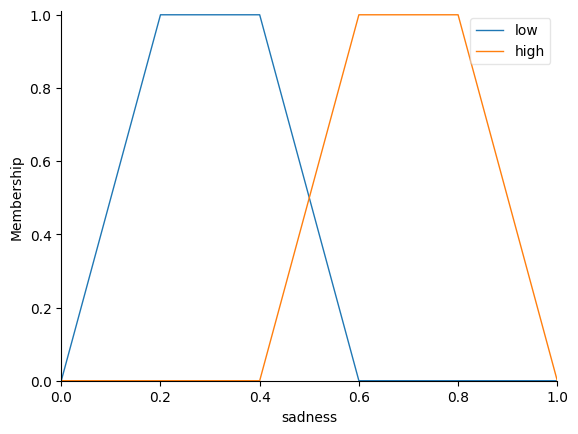

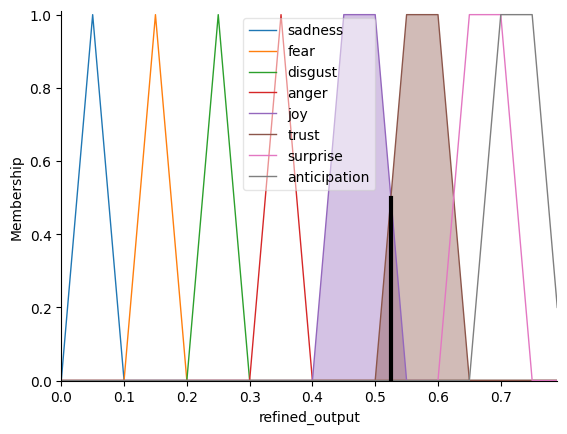

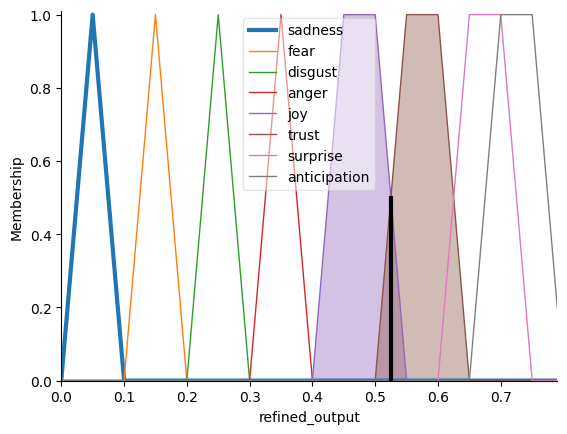

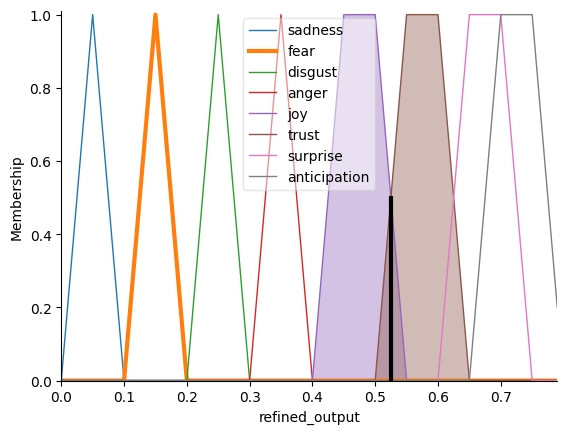

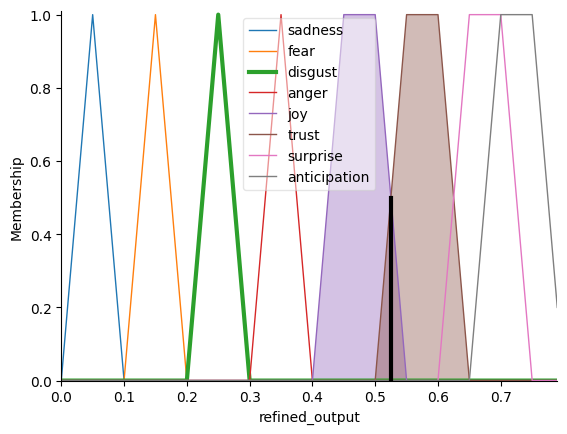

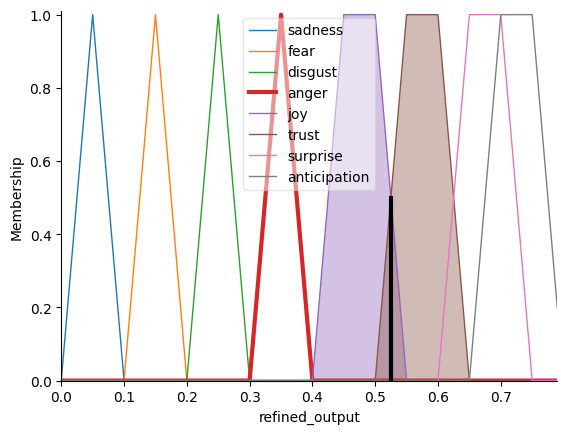

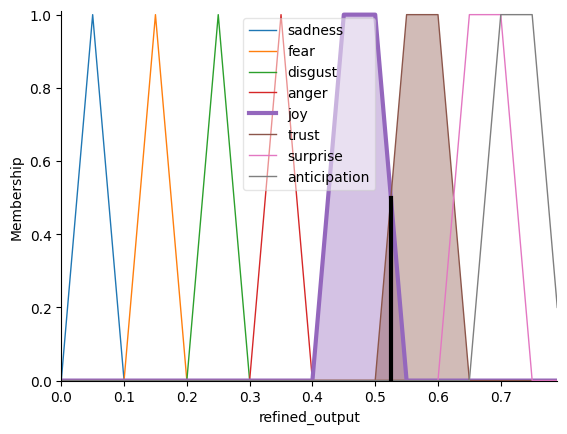

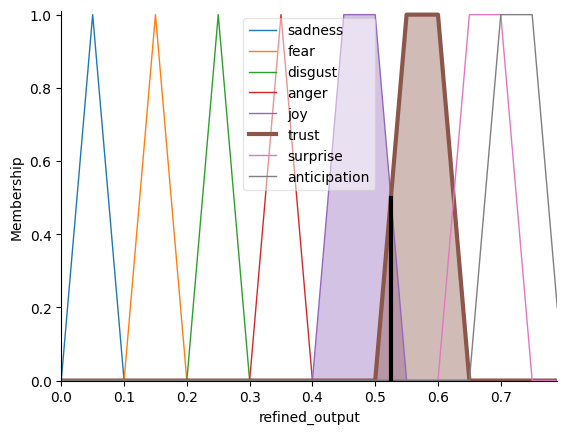

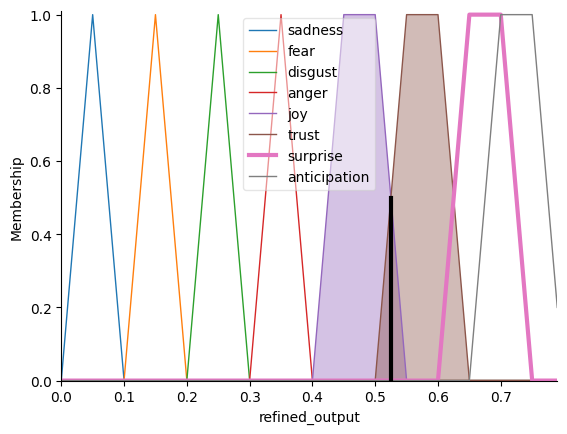

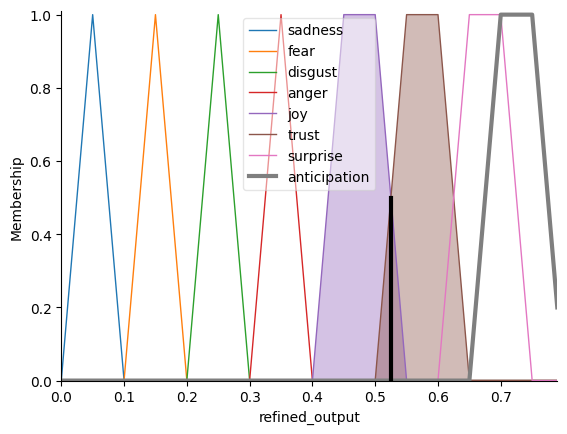

In [1]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import numpy as np

# Define fuzzy variables
emotions = ['sadness', 'fear', 'disgust', 'anger', 'joy', 'trust', 'surprise', 'anticipation']

# Define membership functions for each emotion based on model output probabilities
model_outputs = {emotion: ctrl.Antecedent(np.arange(0, 1.1, .1), emotion) for emotion in emotions}

for emotion in emotions: # todo change to trapezoid and have only high and low
    model_outputs[emotion]['low'] = fuzz.trapmf(model_outputs[emotion].universe, [0, .2, .4, .6])
    model_outputs[emotion]['high'] = fuzz.trapmf(model_outputs[emotion].universe, [.4, .6, .8, 1])
    # model_outputs[emotion]['low'] = fuzz.trimf(model_outputs[emotion].universe, [0, 0, .5])
    # model_outputs[emotion]['medium'] = fuzz.trimf(model_outputs[emotion].universe, [0, .5, 1])
    # model_outputs[emotion]['high'] = fuzz.trimf(model_outputs[emotion].universe, [.5, 1, 1])

print(model_outputs['sadness'].view())

refined_output = ctrl.Consequent(np.arange(0, .8, 0.01), 'refined_output')
refined_output['sadness'] = fuzz.trimf(refined_output.universe, [0,0.05,0.1])
refined_output['fear'] = fuzz.trimf(refined_output.universe, [0.1,0.15,0.2])
refined_output['disgust'] = fuzz.trimf(refined_output.universe, [0.2,0.25,0.3])
refined_output['anger'] = fuzz.trimf(refined_output.universe, [0.3,0.35,0.4])

refined_output['joy'] = fuzz.trapmf(refined_output.universe, [0.4,0.45,0.5,0.55])
refined_output['trust'] = fuzz.trapmf(refined_output.universe, [0.5,0.55,0.6,0.65])
refined_output['surprise'] = fuzz.trapmf(refined_output.universe, [0.6,0.65,0.7,0.75])
refined_output['anticipation'] = fuzz.trapmf(refined_output.universe, [0.65,0.7,0.75,0.8])

rules = []
rules.append(ctrl.Rule(model_outputs['sadness']['low'] | model_outputs['joy']['high'], refined_output['joy']))
rules.append(ctrl.Rule(model_outputs['sadness']['high'] | model_outputs['joy']['low'], refined_output['sadness']))

rules.append(ctrl.Rule(model_outputs['fear']['low'] | model_outputs['trust']['high'], refined_output['trust']))
rules.append(ctrl.Rule(model_outputs['fear']['high'] | model_outputs['trust']['low'], refined_output['fear']))

rules.append(ctrl.Rule(model_outputs['disgust']['low'] | model_outputs['surprise']['high'], refined_output['surprise']))
rules.append(ctrl.Rule(model_outputs['disgust']['high'] | model_outputs['surprise']['low'], refined_output['disgust']))

rules.append(ctrl.Rule(model_outputs['anger']['low'] | model_outputs['anticipation']['high'], refined_output['anticipation']))
rules.append(ctrl.Rule(model_outputs['anger']['high'] | model_outputs['anticipation']['low'], refined_output['anger']))

emotion_ctrl = ctrl.ControlSystem(rules)
fuzzy_system = ctrl.ControlSystemSimulation(emotion_ctrl)    

# values = [0.14033101, 0.04120781, 0.20551428, 0.00233439, 0.00690122, 0.462295, 0.08757105, 0.05384529]
values = [.4, .2, 0, 0, .8, 0, 0, 0]
# Example of how to use the system
# Set inputs
for indx, emotion in enumerate(emotions):
    fuzzy_system.input[emotion] = values[indx]  # Example input, should be set based on actual data

# Compute the output
fuzzy_system.compute()

# Print the output
print(fuzzy_system.output)
# Print the output
print("Emotional Score:", fuzzy_system.output['refined_output'])
refined_output.view(sim=fuzzy_system)
for emotion in emotions:
    refined_output[emotion].view(sim=fuzzy_system)

In [44]:
# # Define fuzzy variables
# emotions = ['disgust', 'anger', 'anticipation', 'sadness', 'joy', 'surprise', 'trust', 'fear']

# # Define membership functions for each emotion based on model output probabilities
# model_outputs = {emotion: ctrl.Antecedent(np.arange(0, 1.1, .1), emotion) for emotion in emotions}
# for emotion in emotions:
#     model_outputs[emotion]['low'] = fuzz.trimf(model_outputs[emotion].universe, [0, 0, .5])
#     model_outputs[emotion]['medium'] = fuzz.trimf(model_outputs[emotion].universe, [0, .5, 1])
#     model_outputs[emotion]['high'] = fuzz.trimf(model_outputs[emotion].universe, [.5, 1, 1])

# # Define the output variable for refined emotion classification
# refined_output = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'refined_output')

# # Define membership functions for refined output
# for emotion in emotions:
#     refined_output[emotion] = fuzz.trimf(refined_output.universe, [0, 0.5, 1])
    
# # refined_outputs = {emotion: ctrl.Consequent(np.arange(0, 11, 1), emotion) for emotion in emotions}
# # for emotion in emotions:
# #     refined_outputs[emotion]['low'] = fuzz.trimf(refined_outputs[emotion].universe, [0, 0.5, 1])
# #     refined_outputs[emotion]['medium'] = fuzz.trimf(refined_outputs[emotion].universe, [0, 0.5, 1])
# #     refined_outputs[emotion]['high'] = fuzz.trimf(refined_outputs[emotion].universe, [0, 0.5, 1])

# # Define fuzzy rules for each emotion
# rules = []
# for emotion in emotions:
#     rules.append(ctrl.Rule(model_outputs[emotion]['low'], refined_output[emotion]))
#     rules.append(ctrl.Rule(model_outputs[emotion]['medium'], refined_output[emotion]))
#     rules.append(ctrl.Rule(model_outputs[emotion]['high'], refined_output[emotion]))

# # Create the control system and simulation
# emotion_ctrl = ctrl.ControlSystem(rules)
# fuzzy_system = ctrl.ControlSystemSimulation(emotion_ctrl)

# # Example of how to use the system
# # Set inputs
# for emotion in emotions:
#     fuzzy_system.input[emotion] = 0.5  # Example input, should be set based on actual data

# # Compute the output
# fuzzy_system.compute()

# # Print the output
# print(fuzzy_system.output)

In [45]:
# Function to apply fuzzy logic on model outputs
def apply_fuzzy_logic(model, inputs):
    predictions = model.predict(inputs)
    refined_predictions = []

    for prediction in predictions:
        # Set each emotion's fuzzy input variable
        for i, emotion in enumerate(emotions):
            fuzzy_system.input[emotion] = prediction[i]
        
        # Compute the fuzzy system
        fuzzy_system.compute()
        
        # Extract the fuzzy output for each emotion
        fuzzy_outputs = {emotion: fuzzy_system.output['refined_output'] for emotion in emotions}
        
        # Print statements for debugging
        print(f"Prediction: {prediction}")
        print(f"Fuzzy outputs: {fuzzy_outputs}")
        
        # Find the emotion with the highest fuzzy output value
        max_emotion = max(fuzzy_outputs, key=fuzzy_outputs.get)
        refined_predictions.append(max_emotion)
    
    return refined_predictions

In [46]:
import tensorflow as tf
from keras.layers import Input, Embedding, Dropout, Bidirectional, LSTM, Concatenate, Dense
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Function to build and train the model
def build_and_train_model(df, max_features, maximum_length=100, embedding_dim=256, dropout_rate=0.5, batch_size=16, epochs=20):
    class_weights = compute_class_weight('balanced', classes=np.unique(df['Emotion']), y=df['Emotion'])
    class_weights = dict(enumerate(class_weights))

    X_text = np.asarray(df['padded'].to_list())
    X_sarcasm = df['Sarcasm'].values.reshape(-1, 1)
    X_irony = df['Irony'].values.reshape(-1, 1)
    X_negation = df['Negation'].values.reshape(-1, 1)
    X_sentiment_polarity = OneHotEncoder().fit_transform(df[['Sentiment Polarity']]).toarray()
    y = pd.get_dummies(df['Emotion']).values #TODO make sure this mapping is the same as the fuzzy inference's

    X_text_train, X_text_val, X_sarcasm_train, X_sarcasm_val, X_irony_train, X_irony_val, X_negation_train, X_negation_val, X_sentiment_polarity_train, X_sentiment_polarity_val, y_train, y_val = train_test_split(
        X_text, X_sarcasm, X_irony, X_negation, X_sentiment_polarity, y, test_size=0.1, random_state=42, stratify=y
    )

    text_input = Input(shape=(maximum_length,), dtype='int32', name='text_input')
    sarcasm_input = Input(shape=(1,), dtype='int32', name='sarcasm_input')
    irony_input = Input(shape=(1,), dtype='int32', name='irony_input')
    negation_input = Input(shape=(1,), dtype='int32', name='negation_input')
    sentiment_polarity_input = Input(shape=(X_sentiment_polarity_train.shape[1],), dtype='int32', name='sentiment_polarity_input')
    inputs = [text_input, sarcasm_input, irony_input, negation_input, sentiment_polarity_input]

    x = Embedding(input_dim=max_features, output_dim=embedding_dim)(text_input)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(60, return_sequences=True))(x)
    x = Attention()(x)

    x = Concatenate()([x, sarcasm_input, irony_input, negation_input, sentiment_polarity_input])
    x = Dense(128, activation='relu')(x)
    outputs = Dense(y.shape[1], activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        [X_text_train, X_sarcasm_train, X_irony_train, X_negation_train, X_sentiment_polarity_train], y_train,
        batch_size=batch_size, epochs=epochs,
        validation_data=([X_text_val, X_sarcasm_val, X_irony_val, X_negation_val, X_sentiment_polarity_val], y_val),
        class_weight=class_weights,
        verbose=0
    )
    
    refined_predictions = apply_fuzzy_logic(model, [X_text_val, X_sarcasm_val, X_irony_val, X_negation_val, X_sentiment_polarity_val])

    return refined_predictions





In [47]:
predictions = build_and_train_model(processed_data, tokenizer_features, maximum_length=100, embedding_dim=128, dropout_rate=0.4, batch_size=128, epochs=20)

print(predictions)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x33065b880> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction: [0.66357994 0.03063141 0.01361668 0.02585511 0.00125873 0.23481576
 0.01181536 0.01842712]
Fuzzy outputs: {'sadness': 0.259674413620648, 'fear': 0.259674413620648, 'disgust': 0.259674413620648

In [18]:
import re
import pandas as pd

def count_punctuation(text):
    exclamation_count = len(re.findall(r'!', text))
    question_count = len(re.findall(r'\?', text))
    ellipsis_count = len(re.findall(r'\.\.\.', text))
    comma_count = len(re.findall(r',', text))
    period_count = len(re.findall(r'\. ', text))
    return pd.Series({
        'exclamation_count': exclamation_count,
        'question_count': question_count,
        'ellipsis_count': ellipsis_count,
        'comma_count': comma_count,
        'period_count': period_count
    })
    
processed_data = processed_data.join(processed_data['Raw_Text'].apply(count_punctuation))
print(processed_data.head())

ValueError: columns overlap but no suffix specified: Index(['exclamation_count', 'question_count', 'ellipsis_count', 'comma_count',
       'period_count'],
      dtype='object')

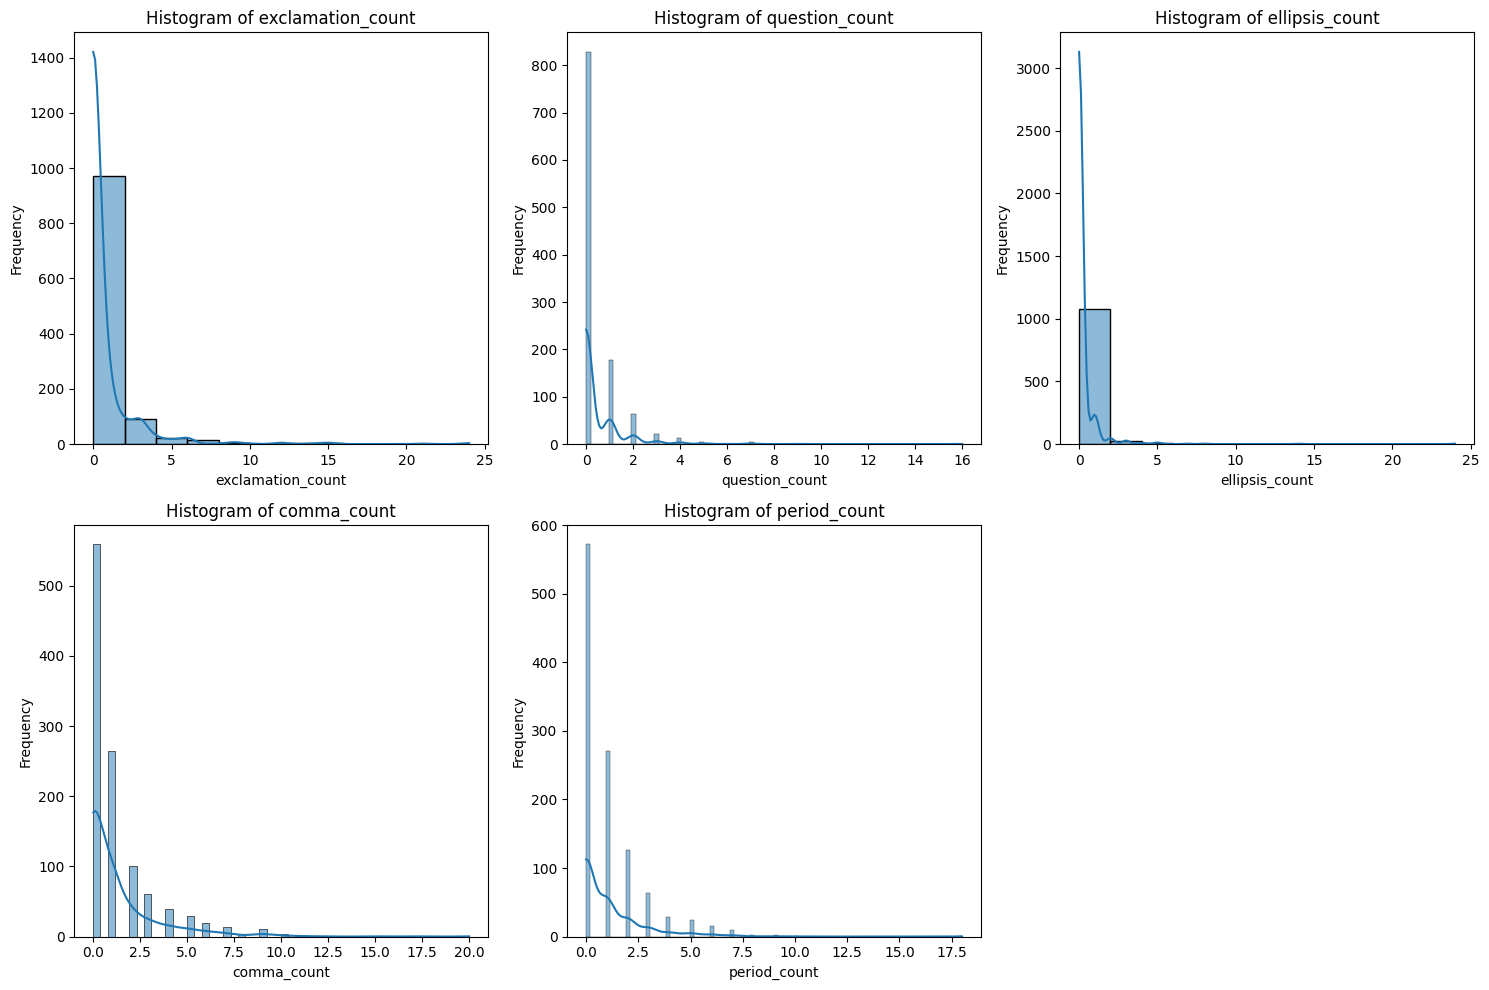

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

columns = ['exclamation_count', 'question_count', 'ellipsis_count', 'comma_count', 'period_count']
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(processed_data[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

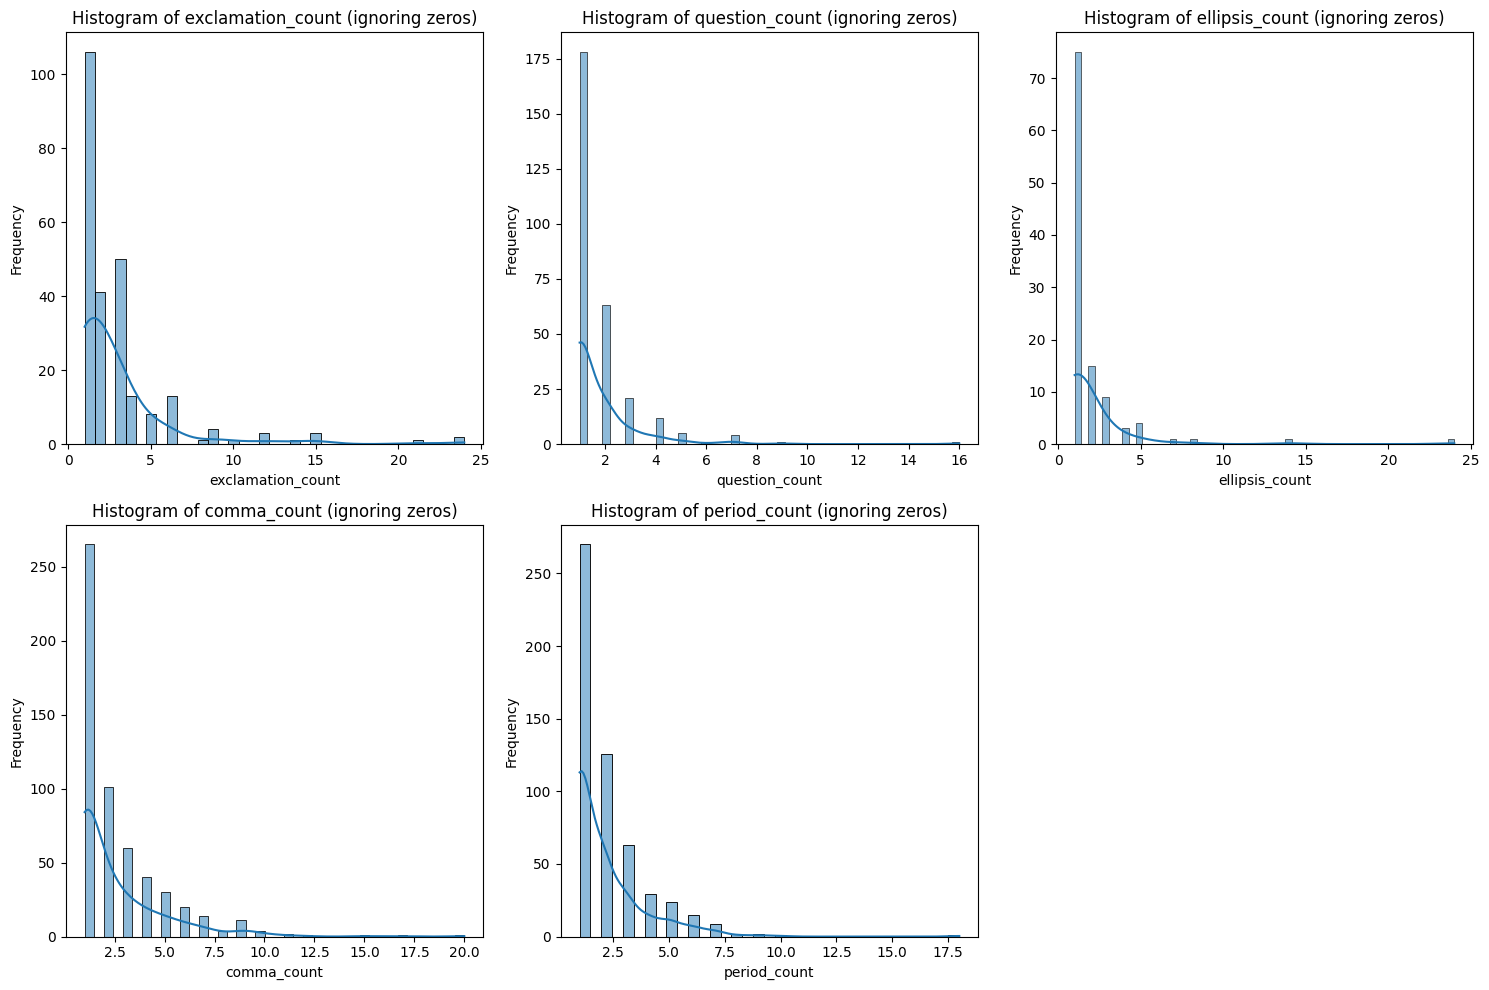

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

columns = ['exclamation_count', 'question_count', 'ellipsis_count', 'comma_count', 'period_count']

plt.figure(figsize=(15, 10))

for i, col in enumerate(columns, 1):
    plt.subplot(2, 3, i)
    non_zero_data = processed_data[col][processed_data[col] > 0]  # Filter out zero values
    sns.histplot(non_zero_data, kde=True) 
    plt.title(f'Histogram of {col} (ignoring zeros)')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import skfuzzy as fuzz

# Define ranges for punctuation counts
punctuation_range = np.arange(0, 10, 1)

# Define membership functions
low_exclamation = fuzz.trimf(punctuation_range, [0, 0, 3])
high_exclamation = fuzz.trimf(punctuation_range, [3, 7, 10])

low_question = fuzz.trimf(punctuation_range, [0, 0, 2])
high_question = fuzz.trimf(punctuation_range, [2, 5, 10])

low_ellipsis = fuzz.trimf(punctuation_range, [0, 0, 1])
high_ellipsis = fuzz.trimf(punctuation_range, [1, 3, 10])

low_comma = fuzz.trimf(punctuation_range, [0, 0, 1])
high_comma = fuzz.trimf(punctuation_range, [1, 3, 10])

low_period = fuzz.trimf(punctuation_range, [0, 0, 1])
high_period = fuzz.trimf(punctuation_range, [1, 3, 10])

In [3]:
# pip install nrclex nltk

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize
from nrclex import NRCLex

processed_data['sentences'] = processed_data['Raw_Text'].apply(sent_tokenize)

# Calculate the number of sentences in each row
processed_data['sentence_count'] = processed_data['sentences'].apply(len)


In [32]:
def analyze_sentiment_change_with_direction(sentences):
    sentiments = []
    sentiment_changes = []
    
    for sentence in sentences:
        sentiment = NRCLex(sentence)
        sentiment_score = sentiment.raw_emotion_scores
        print(sentiment_score)
        filtered_scores = {k: v for k, v in sentiment_score.items() if k in ["positive", "negative"]}
        if filtered_scores:
            highest_sentiment = max(filtered_scores, key=filtered_scores.get)
            sentiment_value = filtered_scores[highest_sentiment]
            if highest_sentiment == "negative":
                sentiment_value = -sentiment_value
            sentiments.append(sentiment_value)
        else:
            sentiments.append(0)  # Default to neutral if no sentiment detected
    
    # Calculate sentiment changes (differences)
    for i in range(1, len(sentiments)):
        change = sentiments[i] - sentiments[i - 1]
        sentiment_changes.append(change)
    
    return sentiments, sentiment_changes

# Apply the function to analyze sentiment changes with direction for each row
# processed_data['sentiments'], processed_data['sentiment_changes'] = zip(*processed_data['sentences'].apply(analyze_sentiment_change_with_direction))


In [33]:
tokens = sent_tokenize("this is a happy day. im incredibly excited about the glorious pretty, happy day. im going to get dark now and it was quite and sad. then things became loud and gloomy, i was upset by this.")
print(analyze_sentiment_change_with_direction(tokens))

{'anticipation': 1, 'joy': 1, 'positive': 1, 'trust': 1}
{'anticipation': 3, 'joy': 3, 'positive': 3, 'surprise': 1, 'trust': 3}
{'sadness': 1}
{'negative': 2, 'sadness': 2, 'anger': 1}
([1, 3, 0, -2], [2, -3, -2])


In [27]:
processed_data['sentiment_change_range'] = processed_data['sentiment_changes'].apply(lambda x: sum(x))

processed_data.head()

,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation,Raw_Text,tokens,padded,masks,sentences,sentence_count,sentiments,sentiment_changes,sentiment_change_range
0,20180001,great budget even cigarette touched great work...,1,positive,trust,0,0,1,Great BUDGET . Even cigarettes were not touche...,"[great, budget, even, cigarette, touched, grea...","[101, 2307, 5166, 2130, 9907, 5028, 2307, 2147...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[Great BUDGET ., Even cigarettes were not touc...",5,"[0, -1, 0, 0, 1]","[-1, 1, 0, 1]",1
1,20180002,exactly scanned budget throughout earth make i...,1,negative,disgust,0,0,1,I haven't exactly scanned the budget throughou...,"[exactly, scanned, budget, throughout, earth, ...","[101, 3599, 11728, 5166, 2802, 3011, 2191, 166...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[I haven't exactly scanned the budget througho...,2,"[-1, -1]",[0],0
2,20180003,already smoking cessation program people want ...,1,neutral,anticipation,0,0,0,There’s already smoking cessation programs for...,"[already, smoking, ce, ##ssa, ##tion, program,...","[101, 2525, 9422, 8292, 11488, 3508, 2565, 211...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[There’s already smoking cessation programs fo...,1,[-2],[],0
3,20180004,alcohol fuel private vehicle raising tax cigar...,1,negative,sadness,0,0,0,So should alcohol and fuel for private vehicle...,"[alcohol, fuel, private, vehicle, raising, tax...","[101, 6544, 4762, 2797, 4316, 6274, 4171, 9907...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[So should alcohol and fuel for private vehicl...,3,"[0, -3, 0]","[-3, 3]",0
4,20180005,practical say third world country supposed eur...,1,negative,anger,0,0,1,Practical? You should say that in a third worl...,"[practical, say, third, world, country, suppos...","[101, 6742, 2360, 2353, 2088, 2406, 4011, 2647...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[Practical?, You should say that in a third wo...",2,"[0, 0]",[0],0


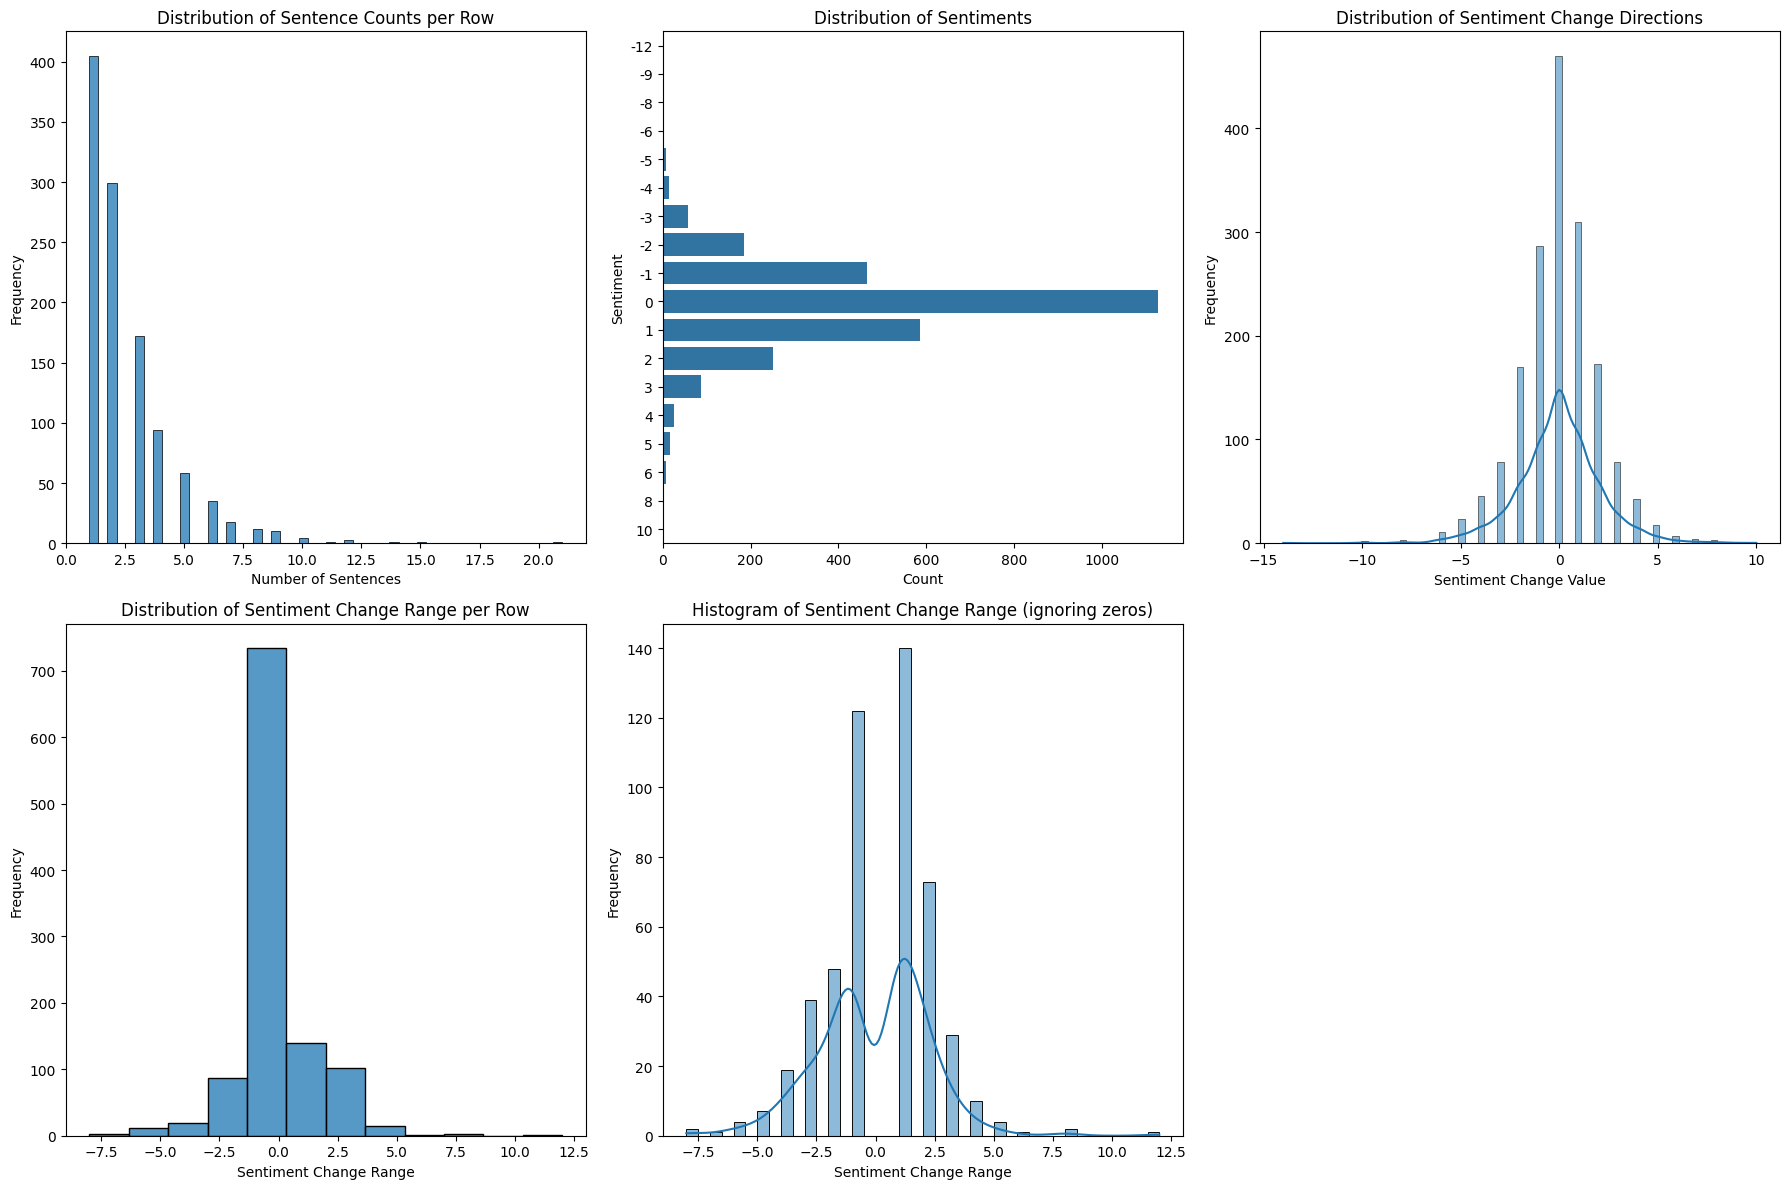

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a grid for the subplots
plt.figure(figsize=(18, 12))

# Plot sentence count distribution
plt.subplot(2, 3, 1)  # Position 1 in a 2x3 grid
sns.histplot(processed_data['sentence_count'], kde=False)
plt.title('Distribution of Sentence Counts per Row')
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')

# Plot sentiment distribution
plt.subplot(2, 3, 2)  # Position 2 in a 2x3 grid
# Flatten the list of sentiments for all rows to plot them in a single graph
all_sentiments = [sentiment for sublist in processed_data['sentiments'] for sentiment in sublist]
sns.countplot(y=all_sentiments)
plt.title('Distribution of Sentiments')
plt.xlabel('Count')
plt.ylabel('Sentiment')

# Plot sentiment change distribution
plt.subplot(2, 3, 3)  # Position 3 in a 2x3 grid
all_sentiment_changes = [change for sublist in processed_data['sentiment_changes'] for change in sublist]
sns.histplot(all_sentiment_changes, kde=True)
plt.title('Distribution of Sentiment Change Directions')
plt.xlabel('Sentiment Change Value')
plt.ylabel('Frequency')

# Plot sentiment change range distribution
plt.subplot(2, 3, 4)  # Position 4 in a 2x3 grid
sns.histplot(processed_data['sentiment_change_range'], kde=False)
plt.title('Distribution of Sentiment Change Range per Row')
plt.xlabel('Sentiment Change Range')
plt.ylabel('Frequency')

# Plot sentiment change range distribution excluding zero values
plt.subplot(2, 3, 5)  # Position 5 in a 2x3 grid
non_zero_data = processed_data['sentiment_change_range'][processed_data['sentiment_change_range'] != 0]  # Filter out zero values
sns.histplot(non_zero_data, kde=True)  # Plot with KDE for smoother appearance
plt.title('Histogram of Sentiment Change Range (ignoring zeros)')
plt.xlabel('Sentiment Change Range')
plt.ylabel('Frequency')

# Adjust layout so that the plots are neatly arranged
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import numpy as np
import skfuzzy as fuzz

# Define the range for sentiment change
sentiment_change_range = np.arange(-10, 10, 0.1)

# Define membership functions
stable = fuzz.trimf(sentiment_change_range, [-0.1, 0, 0.1])
increasing = fuzz.trimf(sentiment_change_range, [0.1, 0.5, 1])
decreasing = fuzz.trimf(sentiment_change_range, [-1, -0.5, -0.1])